# Gene-level analysis of HC association

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import anndata
import warnings 
import scipy.stats
from collections import Counter
import os

warnings.filterwarnings('ignore')
#import scvi_wrapper as s_w
import statsmodels.api as sm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

sc.logging.print_header()
import matplotlib.pyplot as plt
sc.settings.set_figure_params(dpi = 200, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf',fontsize=12)
plt.rcParams["figure.figsize"] = [6,6]
import matplotlib.pyplot as plt 
from matplotlib import font_manager 
font_manager.fontManager.addfont("") 
print(font_manager.findfont("Arial")) 
plt.rcParams["font.sans-serif"] = ["Arial"] 
plt.rcParams["pdf.fonttype"] = 42

In [2]:
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 300, format = 'pdf',fontsize=5)

In [3]:
source_folder = ''

In [4]:
import scvi as scvi

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"
Global seed set to 0


# integrate spatial object 

In [4]:
adata_paed = sc.read_h5ad('')

In [5]:
adata_paed_filt = adata_paed[adata_paed.obs['tot_cell_abundance']>30,:].copy()
adata_paed_filt = adata_paed_filt[adata_paed_filt.obs['n_genes_by_counts']>1000,:].copy()
adata_paed_cma = adata_paed_filt[((adata_paed_filt.obs['annotations_level_1']!="fat")&
                                (adata_paed_filt.obs['annotations_level_0']!="Artifacts")),:].copy()

## remove meduala less lobules 
adata_paed_cma.obs['full_lobule'] = 0
for s in adata_paed_cma.obs['SampleID'].cat.categories.tolist():
    sample = adata_paed_cma[adata_paed_cma.obs['SampleID'].isin([s])]
    for l in sample.obs['annotations_lobules_0'].cat.categories:
        lobule = sample.obs['annotations_lobules_0'] == l
        med = np.where(sample.obs['annotations_level_0'][lobule] == 'Medulla')[0]
        cortex = np.where(sample.obs['annotations_level_0'][lobule] == 'Cortex')[0]
        if (cortex.size>=5) & (med.size>=5):
            adata_paed_cma.obs['full_lobule'][lobule.iloc[np.where(lobule)].index] = 1
adata_paed_cma.obs['full_lobule'] = adata_paed_cma.obs['full_lobule'].astype('category')
adata_paed_cma.obs['full_lobule'].value_counts()
adata_paed_cma = adata_paed_cma[adata_paed_cma.obs['full_lobule']==1] # remove spots that don't have either medullar or cortical data


1    22402
0     3057
Name: full_lobule, dtype: int64

In [6]:
adata_paed_hc = adata_paed_cma.copy()

# Gene expression analysis

In [7]:
adata_paed_hc.layers['raw'] = adata_paed_hc.X.copy()

In [8]:
adata_tmp = adata_paed_hc.copy()
sc.pp.filter_genes(adata_tmp, min_cells=20, inplace = True)
cc_genes =  ['C1orf112', 'KDM1A', 'ARHGAP33', 'CDC27', 'AC004381.6', 'DBF4', 'PRSS21', 'E2F2', 'BAZ1B', 'NCAPD2', 'ANLN', 'BRCA1', 'UBR7', 'DDX11', 'TACC3', 'POLA2', 'DEPDC1', 'NCAPH2', 'HMGB3', 'CENPQ', 'DEPDC1B', 'SPDL1', 'TDP1', 'DSG2', 'NOP16', 'RFC2', 'RAD51', 'POLQ', 'THOC3', 'MRTO4', 'C4orf27', 'POLD1', 'TM7SF3', 'MCM10', 'MTHFD2', 'YBX1', 'ASPM', 'PRR11', 'NUCKS1', 'EXOC5', 'TCOF1', 'RAD18', 'TRIP13', 'DAZAP1', 'HLTF', 'PDCD2', 'SMC1A', 'HMMR', 'MCM2', 'NUP37', 'GTSE1', 'WDR62', 'MCM6', 'MLH1', 'UNG', 'SPAG5', 'UBE2T', 'EXOSC5', 'FAM76B', 'POLD3', 'KIF22', 'PUM3', 'RBL1', 'NDC80', 'HSPB11', 'OXCT1', 'SEH1L', 'ORC1', 'RAD54L', 'NOP14', 'GMCL1', 'AURKA', 'TPX2', 'BIRC5', 'KIF4A', 'FH', 'ORC6', 'G2E3', 'WDR76', 'PHGDH', 'CLSPN', 'NUP50', 'CDC45', 'CDC6', 'CBX5', 'MSH2', 'FKBP5', 'ACOT7', 'CDC7', 'RANBP1', 'CENPM', 'HMGXB4', 'MCM5', 'RANGAP1', 'POLE2', 'CDKN3', 'ERH', 'MTHFD1', 'VRK1', 'EMC9', 'GINS1', 'MYBL2', 'CDC25B', 'PLCB4', 'FAM83D', 'CEP76', 'RBBP8', 'POLA1', 'NUP93', 'CTCF', 'CCP110', 'CEP152', 'OIP5', 'MYEF2', 'MCM4', 'KCTD9', 'RNASEH2A', 'SGTA', 'ASF1B', 'LIG1', 'H2AFV', 'GARS', 'NUDT1', 'RPA3', 'EZH2', 'RHEB', 'SMC3', 'UBE2S', 'RAD51C', 'GALK1', 'C1QBP', 'BLMH', 'TMEM97', 'GAR1', 'NEIL3', 'WHSC1', 'NCAPG', 'CCDC34', 'CCDC86', 'MAGOHB', 'FOXM1', 'GPN3', 'RAD51AP1', 'RFC5', 'NUP107', 'TIMELESS', 'GAPDH', 'CDCA3', 'ENO2', 'FBXO5', 'MCM3', 'BAG2', 'GMNN', 'TTK', 'HMGCS1', 'BRD8', 'KIF20A', 'LMNB1', 'NUP155', 'H2AFY', 'SMC4', 'ECT2', 'CENPA', 'FHL2', 'MSH6', 'DHCR24', 'LRRC42', 'WDR77', 'SRM', 'MAD2L2', 'UCHL5', 'TTF2', 'SLC2A1', 'EBNA1BP2', 'CDC20', 'STMN1', 'NEK2', 'CENPF', 'KIF14', 'CASP8AP2', 'CTNNAL1', 'WDR34', 'PHF19', 'ACYP1', 'EPCAM', 'HELLS', 'CENPL', 'ACAT2', 'MASTL', 'EXOSC8', 'TMPO', 'NFYB', 'NCAPH', 'MND1', 'KIF18A', 'GPSM2', 'GTF3A', 'MRPS2', 'CCDC18', 'CISD1', 'ZWINT', 'CIT', 'DDX39A', 'CENPK', 'CDK2', 'TUBA1B', 'STIL', 'HJURP', 'EXOSC9', 'CKS2', 'ACSL3', 'CSE1L', 'HIST1H1D', 'HIST1H1A', 'DEK', 'GOT2', 'MGME1', 'MCM8', 'HNRNPR', 'BCL2L12', 'TRAP1', 'DLGAP5', 'YEATS4', 'PKMYT1', 'SRD5A3', 'PAICS', 'HAT1', 'KNSTRN', 'DUT', 'E2F8', 'FAM64A', 'MIS18BP1', 'SGOL1', 'RPS4Y1', 'LDLR', 'TOMM40', 'ATP8B3', 'LSM4', 'DNMT1', 'GINS2', 'TUBG1', 'PSMC3IP', 'THOC6', 'TOP2A', 'ENOSF1', 'RAN', 'RPA1', 'PCNA', 'NASP', 'RFC3', 'SLF1', 'LRRCC1', 'CCNB1', 'PSRC1', 'TMEM106C', 'LDHA', 'DDB2', 'CDCA8', 'TPGS2', 'SLC43A3', 'C9orf40', 'TROAP', 'ESPL1', 'NTPCR', 'CKAP2', 'BORA', 'NUDT15', 'BRIP1', 'ACTL6A', 'TXN', 'ODF2', 'SMC2', 'CDK5RAP2', 'ANP32B', 'DSCC1', 'ARHGEF39', 'PPIL1', 'TCF19', 'NRM', 'GGH', 'BUD13', 'CTDSPL2', 'NUSAP1', 'KIF23', 'CASC5', 'CENPO', 'KIF11', 'CEP55', 'KIF20B', 'DNA2', 'BARD1', 'MNS1', 'ZGRF1', 'CENPE', 'HADH', 'SLC39A8', 'NEDD1', 'BRCA2', 'DIAPH3', 'PIF1', 'FANCI', 'TICRR', 'SAMD1', 'SAE1', 'PLK4', 'ITGB3BP', 'KIF2C', 'UCK2', 'NUF2', 'ANP32E', 'DTL', 'ILF2', 'C1orf35', 'HNRNPLL', 'CHAC2', 'POLR2D', 'CDCA7', 'FANCD2', 'CCNA2', 'SKP2', 'PRIM2', 'MMS22L', 'PM20D2', 'MTFR2', 'CDCA5', 'NCAPG2', 'PRPS1', 'GINS4', 'HAUS6', 'CEP78', 'GTF3C5', 'MKI67', 'IMMP1L', 'SSRP1', 'INCENP', 'CCDC15', 'CHEK1', 'DSN1', 'HIRIP3', 'HMGA2', 'TEX30', 'NCAPD3', 'CENPU', 'CENPJ', 'SPC25', 'SUV39H2', 'CENPH', 'CARHSP1', 'CLGN', 'CCSAP', 'BUB3', 'SLFN13', 'SKA1', 'SLC16A1', 'TMEM237', 'ADK', 'FAM122B', 'AIFM1', 'ATAD2', 'SASS6', 'BUB1B', 'CCNB2', 'PSMG3', 'FAIM', 'CDC25C', 'MIS18A', 'ATP5G1', 'IGF2BP1', 'CHAF1B', 'NAE1', 'CCDC58', 'C21orf58', 'ZNF714', 'GPATCH4', 'YDJC', 'RACGAP1', 'SPC24', 'POLR3K', 'CCNF', 'ASRGL1', 'USP1', 'KIAA1524', 'SGOL2', 'TOPBP1', 'KIF15', 'WDR43', 'RFC4', 'RPL39L', 'RNF168', 'H2AFZ', 'CDC25A', 'POC1A', 'HMGB2', 'MAD2L1', 'PTTG1', 'RAD21', 'PSIP1', 'GKAP1', 'MELK', 'SLC7A3', 'SKA3', 'LRR1', 'HPRT1', 'E2F7', 'JAM3', 'BRD7', 'CENPN', 'LEO1', 'WEE1', 'MCM7', 'CENPV', 'SAAL1', 'FAM111A', 'KIAA0101', 'PLK1', 'XRCC6BP1', 'SNRPD1', 'RRM1', 'CDT1', 'CHAF1A', 'C19orf48', 'NUDT8', 'PRDX2', 'TK1', 'SAC3D1', 'PBK', 'HIST1H1E', 'DTYMK', 'RFWD3', 'FEN1', 'ING2', 'CDKN2AIP', 'SNRNP48', 'USP39', 'CKAP2L', 'BUB1', 'ELP5', 'CDK1', 'CDCA4', 'SHCBP1', 'PGAM1', 'ESCO2', 'RHNO1', 'CTPS1', 'RRM2', 'THOP1', 'C5orf34', 'POP7', 'ZNF738', 'CKS1B', 'GMPPB', 'CNP', 'CBX2', 'C16orf91', 'EXO1', 'ZWILCH', 'ANKRD36C', 'UBE2C', 'CKAP5', 'CCNE2', 'CCDC14', 'RMI2', 'TOMM5', 'RUVBL1', 'ATAD5', 'LMNB2', 'TYMS', 'PXMP2', 'SHMT1', 'POLE', 'PAWR', 'PIDD1', 'GSG2', 'GEN1', 'RMI1', 'AURKB', 'RCC1', 'PPA1', 'HIST3H2A', 'MRPS23', 'RTKN2', 'IDH2', 'KPNA2', 'CEP97', 'GLRX5', 'SKA2', 'CEP57L1', 'PSMG1', 'SFXN4', 'ALYREF', 'TRAIP', 'LIN9', 'KMT5A', 'PGP', 'CMSS1', 'HIST2H2AC', 'HIST1H1B', 'KNTC1', 'CDCA2', 'H1FX', 'SIVA1', 'PARPBP', 'KIF18B', 'ERCC6L', 'PTMA', 'HSPA14', 'FANCA', 'ARHGAP11B', 'TUBB4B', 'CENPP', 'H2AFX', 'FAM72B', 'FAM221A', 'FAM111B', 'HN1', 'HMGB1', 'TUBB', 'IARS', 'ERI2', 'HIST1H4C', 'BLM', 'PRIM1', 'HMGN5', 'SVIP', 'TFDP1', 'TXNRD1', 'WDHD1', 'EIF1AY', 'ARHGAP11A', 'HMGN2', 'DCAF12', 'PRC1', 'CCDC167', 'CENPW', 'GPANK1', 'MZT1', 'C4orf46', 'KLHL23', 'MXD3', 'DNAJC9', 'IFRD2', 'CKLF', 'FANCG', 'DHFR', 'DLEU2', 'AP000251.3', 'KIFC1', 'CRNDE', 'C8orf88', 'PRKDC', 'BOP1', 'RP11-196G18.23', 'CTC-260E6.6', 'NCBP2-AS2', 'HIST1H3G', 'HIST1H2AH', 'UHRF1', 'RDM1', 'HIST1H2AM']
import re
def remove_selected_genes(adata,lst,remove_also_mt=True, remove_vdj = True):
    for g in lst:
        adata = adata[:,~(adata.var_names==g)]
    if remove_also_mt:
        adata = adata[:,~(adata.var_names.str.startswith('MT-'))]
    if remove_vdj:
        vdj = [i for i in adata.var_names if re.search('^TR[AB][VDJ]|^IG[HKL][VDJC]', i)]
        print(vdj)
        adata = adata[:,~(adata.var_names.isin(vdj))]
    return adata

adata_tmp = remove_selected_genes(adata_tmp,cc_genes,remove_also_mt=True, remove_vdj = True)  


['IGKC', 'IGKV4-1', 'TRBV2', 'TRBV3-1', 'TRBV4-1', 'TRBV5-1', 'TRBV6-1', 'TRBV4-2', 'TRBV6-2', 'TRBV7-2', 'TRBV7-3', 'TRBV9', 'TRBV6-5', 'TRBV5-4', 'TRBV6-6', 'TRBV5-6', 'TRBV6-8', 'TRBV7-9', 'TRBV13', 'TRBV10-3', 'TRBV12-4', 'TRBV14', 'TRBV15', 'TRBV16', 'TRBV18', 'TRBV19', 'TRBV20-1', 'TRBV21-1', 'TRBV23-1', 'TRBV24-1', 'TRBV27', 'TRBV28', 'TRBV29-1', 'TRBV30', 'TRAV1-1', 'TRAV1-2', 'TRAV4', 'TRAV5', 'TRAV6', 'TRAV8-2', 'TRAV8-3', 'TRAV13-1', 'TRAV12-2', 'TRAV8-4', 'TRAV13-2', 'TRAV14DV4', 'TRAV12-3', 'TRAV8-6', 'TRAV16', 'TRAV17', 'TRAV19', 'TRAV20', 'TRAV21', 'TRAV22', 'TRAV23DV6', 'TRAV26-1', 'TRAV27', 'TRAV29DV5', 'TRAV30', 'TRAV26-2', 'TRAV34', 'TRAV35', 'TRAV36DV7', 'TRAV38-1', 'TRAV38-2DV8', 'TRAV39', 'TRAV40', 'TRAV41', 'IGHD', 'IGHV1-2', 'IGHV1-3', 'IGHV1-24', 'IGHVIII-38-1', 'TRADD', 'IGLV6-57', 'IGLV1-51', 'IGLV2-23', 'IGLV3-21', 'IGLV2-14', 'IGLV2-11', 'IGLV2-8', 'IGLV3-1', 'IGLC1', 'IGLC2', 'IGLC3', 'IGLC5', 'IGLC6', 'IGLC7']


In [9]:
adata_tmp = adata_tmp.copy()
import warnings
warnings.filterwarnings('once')
scvi.model.SCVI.setup_anndata(adata_tmp, batch_key='SampleID',layer='raw', \
                        categorical_covariate_keys=['SlideID','section_thickness (um)'],
                              continuous_covariate_keys=['Age(numeric)','n_genes_by_counts'])
vae = scvi.model.SCVI(adata_tmp,n_layers=2, n_latent=30)
vae.train(max_epochs=300,batch_size=2000)
adata_paed_hc.obsm["X_scVI"] = vae.get_latent_representation() # return batch corrections to original anndata
sc.pp.neighbors(adata_paed_hc, use_rep="X_scVI")
sc.tl.umap(adata_paed_hc, min_dist = 0.01, spread = 1)
# sc.tl.leiden(adata_paed_hc, resolution=0.5,key_added='leiden_05')
# sc.tl.leiden(adata_paed_hc, resolution=1,key_added='leiden_1')

INFO     Using batches from adata.obs["SampleID"]                                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["raw"]                                                 
INFO     Successfully registered anndata object containing 22402 cells, 20728 vars, 16       
         batches, 1 labels, and 0 proteins. Also registered 2 extra categorical covariates   
         and 2 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [11:24<00:00,  2.28s/it, loss=7.69e+03, v_num=1]


In [10]:
adata_tmp.layers['scvi_norm'] = vae.get_normalized_expression(adata=None, indices=None, transform_batch=None, gene_list=None, library_size=1, n_samples=1, n_samples_overall=None, batch_size=None, return_mean=True, return_numpy=None)

adata_tmp.X = adata_tmp.layers['scvi_norm'].copy()

sc.pp.normalize_total(adata_tmp, target_sum=5000) #vs 2500

adata_tmp.write(f'HTSA_adata_vis_scvi_corrected_v5.h5ad')

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Plotting on the HCs vs CMA axes

In [6]:
adata_scvi = sc.read('HTSA_adata_vis_scvi_corrected_v5.h5ad')

In [7]:
adata_paed_hc_filt = adata_scvi[adata_scvi.obs['n_genes_by_counts']>1500,:].copy()

In [8]:
# version 3 hybrid
def mean_space_gene(adata_vis,anno,threshold = 0.5,minspots=20):
    space_map = {}
    obs_ind = np.where(adata_vis.obs.columns == anno)[0]
    for c in adata_vis.var_names:
        temp = adata_vis.X[:,adata_vis.var_names==c]
        points_above = np.where(temp>threshold)[0]
        if len(points_above)>minspots:
                spot_counts = np.squeeze(np.array(temp)[points_above])      
                axis_value = np.squeeze(np.array(adata_vis.obs.iloc[points_above,obs_ind]))
                space_map[c] = (np.dot(spot_counts,axis_value)/np.sum(spot_counts))
    return space_map

idx = np.where((adata_paed_hc[:,'MUC4'].X>0.5).todense())[0]

In [9]:
np.where((adata_scvi[:,'MUC4'].X>1))[0]

array([], dtype=int64)

In [10]:
%%time
space_map_cma = mean_space_gene(adata_paed_hc_filt,'cma_v2',threshold=0.2,minspots=20)
space_map_hc = mean_space_gene(adata_paed_hc_filt,'L2_dist_annotations_level_1_HS',threshold=0.2,minspots=20)

CPU times: user 6min 18s, sys: 10min 41s, total: 16min 59s
Wall time: 4min 17s


In [11]:
space_map_cma_filt = {}
for i in space_map_cma:
    if space_map_cma[i]!=None:
        if space_map_cma[i]>0.55:
            space_map_cma_filt[i] = space_map_cma[i] # remove cells that are not medullar centered  
print(len(space_map_cma_filt))

867


In [12]:
space_map_hc_filt = {}
for i in space_map_cma_filt:
#     space_map_hc[i] = space_map_hc[i]*2 # correct back to linear and micron distance ppm=0.5 hence the 2 
    if space_map_hc[i]<350/2:
        if space_map_hc[i]!=None:
                space_map_hc_filt[i] = space_map_hc[i]*2 # space_map_hc[i]*2 # correct back to linear and micron distance ppm=0.5 hence the 2 
print(len(space_map_hc_filt))

867


## generate genes that are cadidates for marker genes 
keys_list = np.array(list(space_map_hc_filt.keys()))
np.save('Candidate_broad_HC_genes_v2.npy', keys_list)


In [13]:
# read back marker genes 
marker_dict_1 = np.load('',allow_pickle=True).item()

In [14]:
len(marker_dict_1.keys())

14

In [15]:
sgs = []
[sgs.extend(marker_dict_1[key]) for key in marker_dict_1]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [39]:
df = pd.DataFrame.from_dict({'space_map_cma': space_map_cma_filt, 'space_map_hc': space_map_hc_filt}, orient='index').T.dropna()

In [40]:
len(sgs)

184

In [41]:
len(marker_dict_1.keys())

14

In [42]:
search_strings = ['KLK6', 'KLK7', 'KLK8', 'CXCL17', 'MUC4', 'PSCA', 'TNNT1', 'TNNT2', 'TNNC1', 'TNNC2', 'TNNI1']

In [43]:
count_dict = {}
for key in marker_dict_1.keys():
    count_dict[key]= len(marker_dict_1[key])

In [44]:
count_dict

{'B-memory': 3,
 'DC1': 3,
 'Macrophage-APOC2': 1,
 'TEC-cilliated': 1,
 'TEC-myo': 18,
 'TEC-neuro': 1,
 'T_CD8αα(II)': 1,
 'T_NK': 2,
 'T_Treg_recirc': 3,
 'aDC1': 1,
 'aDC3': 1,
 'mTECII': 53,
 'mTECIII': 93,
 'pDC': 3}

In [47]:
color_dict = {'B-memory':'#D1D646',
              'Macrophage-APOC2':'#2CA02C',
               'T_CD8αα(II)':'#7E56A8',
              'T_NK': '#8C564B',
              'DC1':'#FF7F0E',
              'aDC1': '#40434E',
              'aDC3': '#7F7F7F',
              'pDC':'#FF391F',
              'T_Treg_recirc': '#E377C2',
              'mTECII':'#018DE8',
              'mTECIII': '#A74C56',
              'TEC-myo': '#597000',
              'TEC-neuro':'#FFC600',
              'TEC-cilliated': '#F7A072'}

In [45]:
df['ctype'] = 'nan'
for key, values in marker_dict_1.items():
    df.loc[df.index.isin(values), 'ctype'] = key

In [48]:
df.to_csv(f'{source_folder}/HC_vs_CMA_weighted_gene_position.csv')

In [26]:
def annotate_matching_positions(search_string):
    matching_positions = np.where(df.index.str.contains(search_string))[0]
    df_tmp = df.iloc[matching_positions, :]
#    plt.scatter(df_tmp['space_map_cma'], df_tmp['space_map_hc'], c=color, label=search_string, s=50)
    for i in matching_positions:
        plt.annotate(df.index[i], (df['space_map_cma'][i], df['space_map_hc'][i]), fontname='Arial', fontsize=15, color="black")


In [27]:
search_strings = ['KLK6', 'KLK7', 'KLK8', 'CXCL17', 'MUC4', 'PSCA', 'TNNT1', 'TNNT2', 'TNNC1', 'TNNC2', 'TNNI1', 'TNNT3']

In [30]:
marker_dict_1

{'B-memory': ['PAX5', 'CD19', 'CD22'],
 'DC1': ['SLAMF8', 'XCR1', 'ANPEP'],
 'Macrophage-APOC2': ['MMP12'],
 'TEC-cilliated': ['C20orf85'],
 'TEC-myo': ['TNNT2',
  'TNNI1',
  'ACTA1',
  'MYL1',
  'DES',
  'TNNC1',
  'MYL5',
  'FLNC',
  'TNNT3',
  'MYH7',
  'ACTC1',
  'MYLPF',
  'MYH3',
  'MYL4',
  'CKM',
  'AC020909.2',
  'TNNT1',
  'TNNC2'],
 'TEC-neuro': ['DEFA5'],
 'T_CD8αα(II)': ['ZNF683'],
 'T_NK': ['GNLY', 'KLRB1'],
 'T_Treg_recirc': ['TNFRSF18', 'TIGIT', 'LAG3'],
 'aDC1': ['IL12B'],
 'aDC3': ['BX255923.2'],
 'mTECII': ['NPPA',
  'NPPB',
  'PLA2G2A',
  'LCE3D',
  'LCE1E',
  'LCE1C',
  'LCE1B',
  'SPRR2A',
  'SPRR2G',
  'PRR9',
  'MARCO',
  'CCK',
  'SST',
  'LRRC15',
  'FDCSP',
  'CXCL13',
  'FABP6',
  'TRIM31',
  'MLN',
  'KHDC1L',
  'AZGP1',
  'DEFB4B',
  'DEFB4A',
  'SFTPA2',
  'SFTPA1',
  'CALCA',
  'SCGB1D1',
  'SCGB2A2',
  'SCGB1A1',
  'APOA4',
  'APOC3',
  'APOA1',
  'DCD',
  'TVP23A',
  'PRM2',
  'MT4',
  'MT1G',
  'CCL7',
  'CCL1',
  'GAST',
  'PYY',
  'CSH2',
  'NPB',
 

,space_map_cma,space_map_hc,B-memory_unique,DC1_unique,Macrophage-APOC2_unique,TEC-cilliated_unique,TEC-myo_unique,TEC-neuro_unique,T_CD8αα(II)_unique,T_NK_unique,T_Treg_recirc_unique,aDC1_unique,aDC3_unique,mTECII_unique,mTECIII_unique,pDC_unique
AL390719.2,0.644187,53.240675,False,False,False,False,False,False,False,False,False,False,False,False,False,False
TNFRSF18,0.639795,134.900104,False,False,False,False,False,False,False,False,True,False,False,False,False,False
TNFRSF4,0.573268,157.850057,False,False,False,False,False,False,False,False,False,False,False,False,False,False
TP73,0.638041,119.868947,False,False,False,False,False,False,False,False,False,False,False,False,False,False
HES2,0.661702,27.700445,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCEAL7,0.623388,31.721564,False,False,False,False,False,False,False,False,False,False,False,False,False,False
IL13RA1,0.553955,154.238594,False,False,False,False,False,False,False,False,False,False,False,False,False,False
ZCCHC12,0.702394,45.963790,False,False,False,False,False,False,False,False,False,False,False,False,False,False
PNMA3,0.599621,198.345129,False,False,False,False,False,False,False,False,False,False,False,False,False,False


B-memory


DC1


Macrophage-APOC2


TEC-cilliated


TEC-myo


TEC-neuro


T_CD8αα(II)


T_NK


T_Treg_recirc


aDC1


aDC3


mTECII


mTECIII


pDC


Text(0.5, 0, 'space_map_cma')

Text(0, 0.5, 'space_map_hc')

(0.75, 0.55)

(0.0, 250.0)

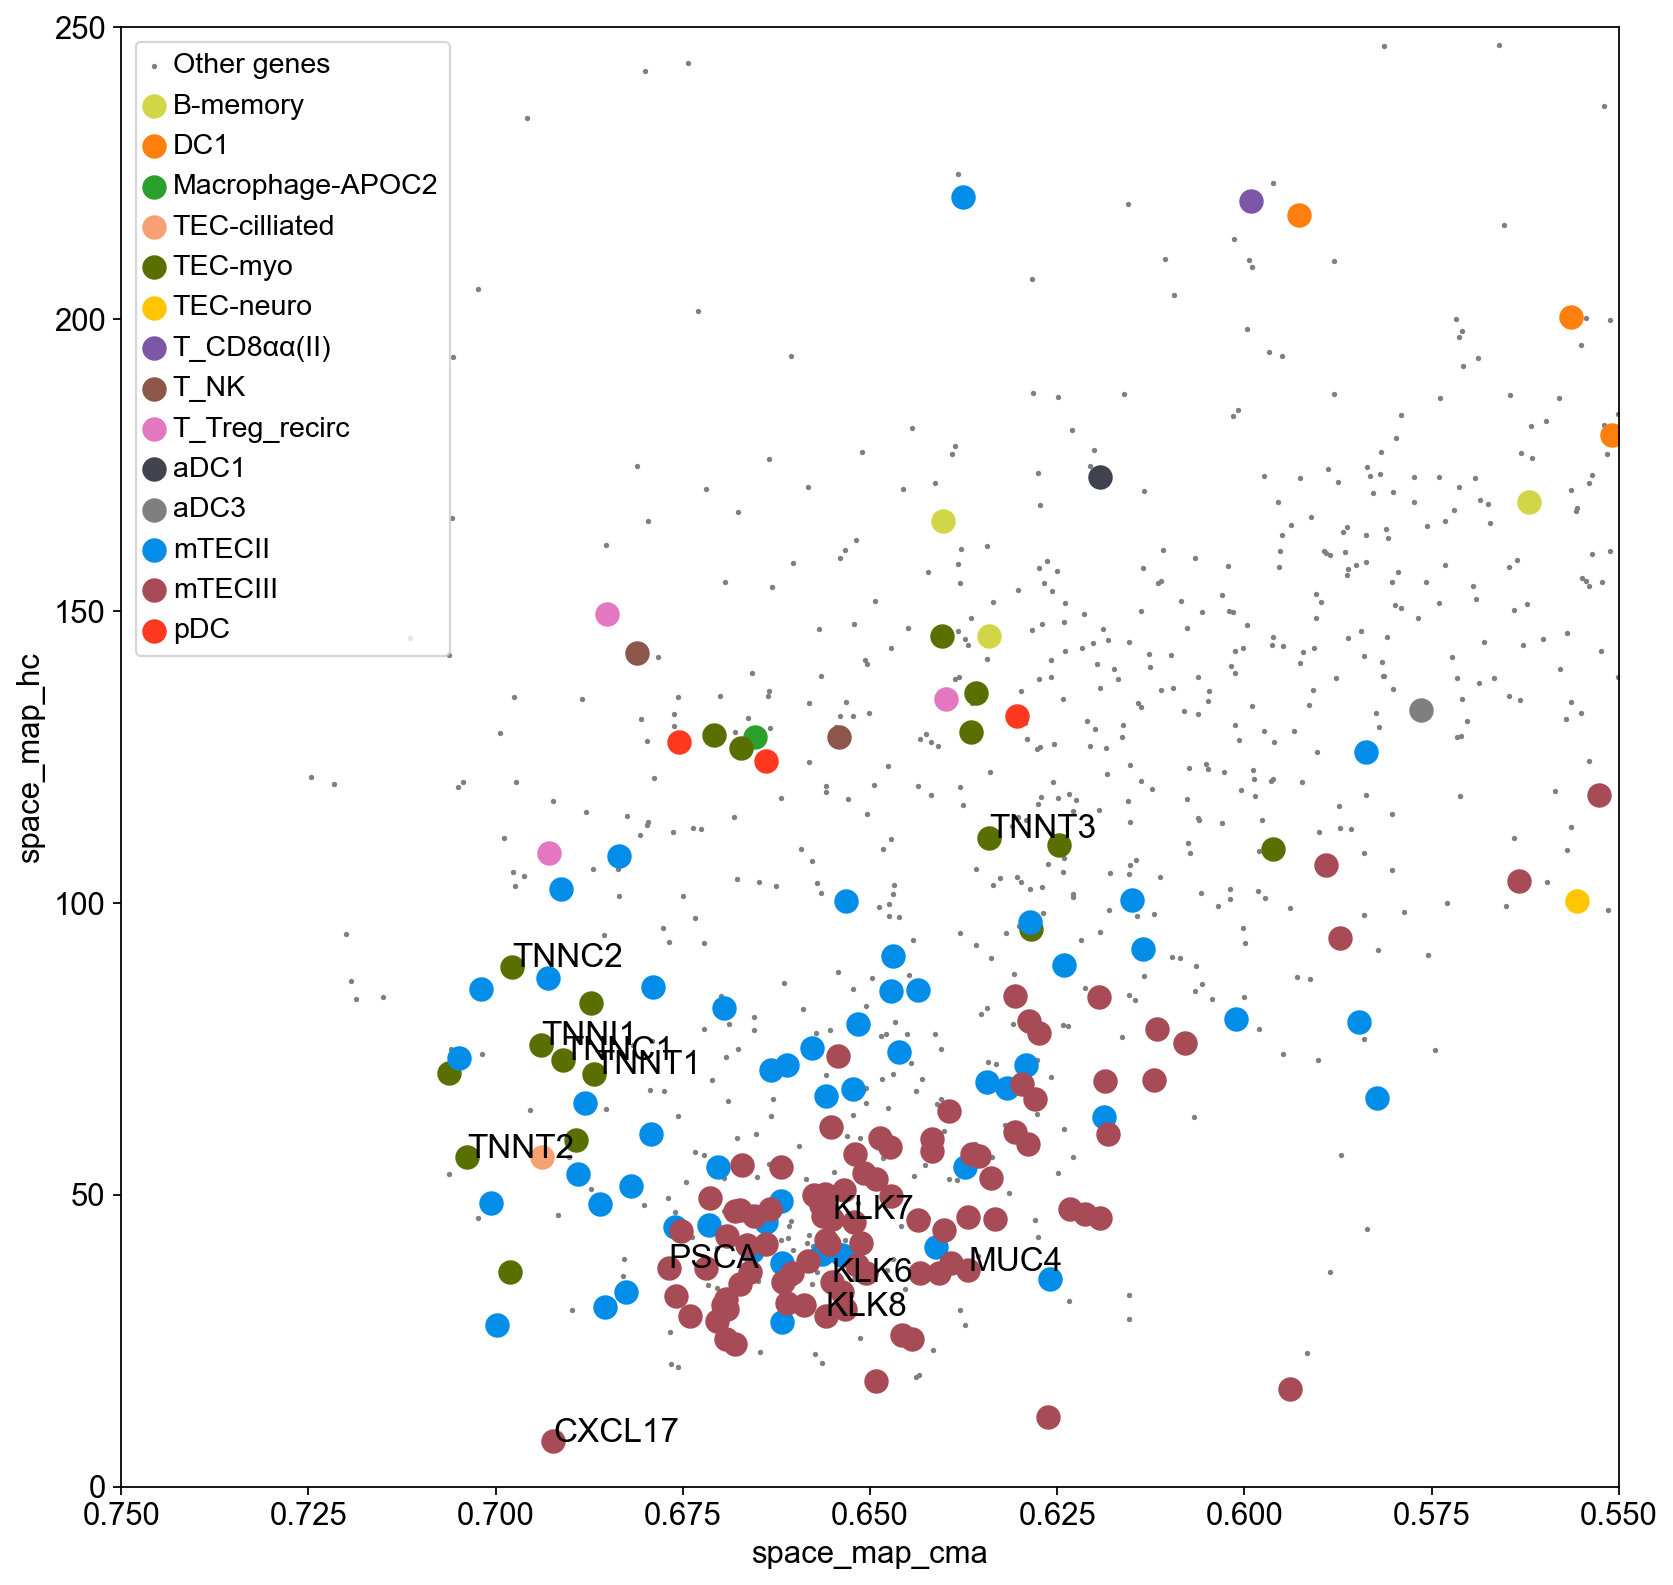

In [28]:
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=[12,12],fontsize=14)
cmap = plt.get_cmap('tab20')
cell_spots = {}
for key in marker_dict_1.keys():
    df[key+'_unique'] = df.index.isin(marker_dict_1[key])
df

colors = sns.color_palette('tab20', 11)
# cmap = ListedColormap(colors)

plt.scatter(df['space_map_cma'], df['space_map_hc'], c='gray', label='Other genes', s=2)
for idx, key in enumerate(marker_dict_1.keys()):
    print(key)
    plt.scatter(df[df[key + '_unique']]['space_map_cma'], df[df[key + '_unique']]['space_map_hc'], c=color_dict[key], label=key, s=100)
#    if 'TEC' not in key:
#        plt.scatter(df[df[key + '_unique']]['space_map_cma'], df[df[key + '_unique']]['space_map_hc'],  c=[colors[idx]], label=key, s=100)
# Use a loop to match partial strings, plot scatter points, and add annotations
for search_string in search_strings:
    annotate_matching_positions(search_string)
        
plt.grid(False)

# add axis labels
plt.xlabel('space_map_cma')
plt.ylabel('space_map_hc')

plt.legend()
plt.gca().invert_xaxis()

# Set axis limits
plt.xlim(0.75, 0.55) # Since you're inverting the x-axis, the limits are given in reverse order
plt.ylim(0, 250)

plt.savefig('')
plt.show()


## 